# Setup

In [1]:
from secular_pt_fun import *
from secular_pt_param import *

In [2]:
data_dir = '/mnt/home/kvantilburg/ceph/GravitationalBasin/sec_pt_2/'
fig_dir = '../figs/'

In [3]:
plt.rcdefaults()
plt.style.use('rc.mplstyle')

<ipython-input-3-bc964f95bcc0>:2: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  plt.style.use('rc.mplstyle')
/mnt/home/kvantilburg/miniconda3/envs/ss_sim/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


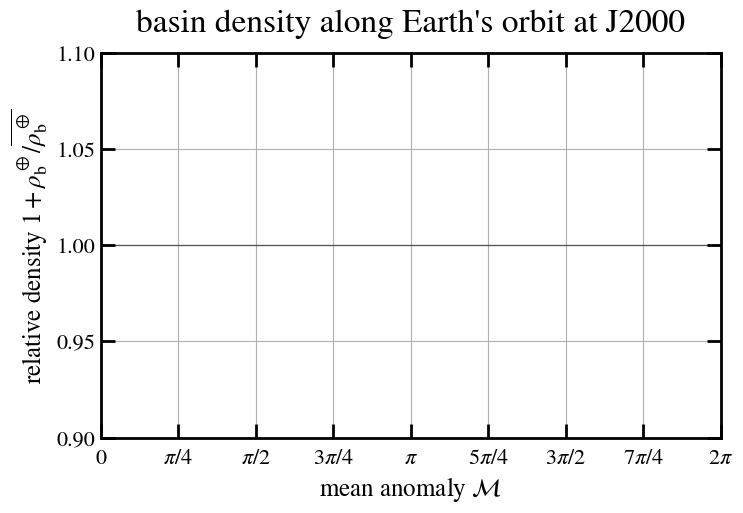

In [4]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.axhline(1,color=(0,0,0,0.5),lw=1)
ax.set_xlim(0,2*np.pi);
ax.set_xticks(np.arange(0,2*np.pi+1e-10,np.pi/4))
ax.set_xticklabels([0,r'$\pi/4$','$\pi/2$','$3\pi/4$','$\pi$','$5\pi/4$','$3\pi/2$','$7\pi/4$','$2\pi$'])
ax.set_xlabel(r'mean anomaly $\mathcal{M}$')
ax.set_ylabel(r'relative density $1 + \rho_\mathrm{b}^\oplus / \overline{\rho_\mathrm{b}^\oplus}$')
ax.set_ylim(0.9,1.10);
ax.set_title(r"basin density along Earth's orbit at J2000")
ax.grid()
fig

# Parameters

units of time: $\mathrm{year} = 2 \pi$;
units of distance: $\mathrm{AU} = 1$;
units of speed: $\sqrt{\frac{GM}{\mathrm{AU}}} = 1$

In [5]:
#print(e_il,inc_il,g_l,f_l,beta_l,gamma_l)
df_planets

,name,a,lambda,e,inc,omega,Omega,T,m/M
0,Mercury,0.3871,4.402593,0.20564,0.122278,1.351932,0.843692,0.241,1.659000e-07
1,Venus,0.7233,3.176150,0.00676,0.059306,2.299820,1.338144,0.615,2.447000e-06
2,Earth,1.0000,1.753532,0.01673,0.000000,1.796467,0.000000,1.000,3.039000e-06
3,Mars,1.5237,6.203424,0.09337,0.032323,5.865703,0.867603,1.881,3.226000e-07
4,Jupiter,5.2025,0.599172,0.04854,0.022672,0.249058,1.750391,11.870,9.542000e-04
5,Saturn,9.5415,0.874061,0.05551,0.043529,1.620713,1.983392,29.470,2.857000e-04
6,Uranus,19.1880,5.483825,0.04686,0.013491,3.009471,1.290846,84.050,4.353000e-05
7,Neptune,30.0700,5.309641,0.00895,0.030892,0.814720,2.300169,164.900,5.165000e-05


In [6]:
df_planets['omega'].to_numpy() - df_planets['omega'][2]

array([-0.44453536,  0.50335296,  0.        ,  4.06923515, -1.54740891,
       -0.17575466,  1.21300383, -0.9817477 ])

# Secular simulation

## Setup

In [7]:
n_a = int(1e3)
a_min = 0.4
a_max = 10.
vec_a = np.arange(a_min,a_max,(a_max-a_min)/n_a)
prob_a = vec_a**(-2)/np.sum(vec_a**(-2)); # pdf that scales as f(a) \propto 1/a^2

n_e = int(1e3)
e_min = 0
e_max = 1
vec_e = np.arange(e_min,e_max,(e_max-e_min)/n_e)
prob_e = vec_e / np.sum(vec_e) # pdf scales as f(e) \propto e

n_inc = int(1e3)
inc_min = 0
inc_max = np.pi
vec_inc = np.arange(inc_min,inc_max,(inc_max-inc_min)/n_inc)
prob_inc = np.sin(vec_inc) / np.sum(np.sin(vec_inc))

In [8]:
n_sample = 2**10 # ideally power of 2 for FFT purposes
pts_xy_Earth_orbit = fn_gen_pts_xyz(df_planets[df_planets['name']=='Earth']['a'].to_numpy()[0],
                                    df_planets[df_planets['name']=='Earth']['e'].to_numpy()[0],
                                    n_points=n_sample)[:2,:]

In [9]:
# test parameters
n_orbits = int(1e2)
n_saves = int(5e2)
n_t_0 = int(1e3)
n_points = int(1e3)
n_bins_xy = int(1e2); n_bins_z = int(1e2);
lim_xy = 1.2; lim_z = 1.2;
bins_xy = np.linspace(-lim_xy,lim_xy,n_bins_xy);
bins_z = np.linspace(-lim_z,lim_z,n_bins_z);
t = 0

## Run

## Analysis along trajectory

### Processing

In [10]:
list_files = os.listdir(data_dir)
list_files = [file for file in list_files if file[:11]=='hist_strap_']
print(len(list_files))
list_files = list_files[:10000]
len(list_files)

10028


10000

In [11]:
hist_strap = np.zeros((len(list_files),n_bins_xy-1,n_bins_xy-1))
dens_sample_strap = np.zeros((len(list_files),n_sample))
dens_sample_fft_strap = np.zeros((len(list_files),n_sample//2+1),dtype=np.complex64)

In [12]:
M_sample = np.arange(0,2*np.pi,2*np.pi/n_sample)

In [13]:
hist = np.load(data_dir+'hist.npy')
hist_strap = np.load(data_dir+'hist_strap.npy')
dens_sample_strap = np.load(data_dir+'dens_sample_strap.npy')
dens_sample_fft_strap = np.load(data_dir+'dens_sample_fft_strap.npy')

In [14]:
hist_strap.shape

(10000, 99, 99)

### Height variation

In [15]:
interp = interp2d((bins_xy[:-1]+bins_xy[1:])/2,(bins_xy[:-1]+bins_xy[1:])/2,hist[:,:,(n_bins_z-1)//2]);
interp_m = interp2d((bins_xy[:-1]+bins_xy[1:])/2,(bins_xy[:-1]+bins_xy[1:])/2,hist[:,:,(n_bins_z-1)//2-1]);
interp_m2 = interp2d((bins_xy[:-1]+bins_xy[1:])/2,(bins_xy[:-1]+bins_xy[1:])/2,hist[:,:,(n_bins_z-1)//2-2]);
interp_p = interp2d((bins_xy[:-1]+bins_xy[1:])/2,(bins_xy[:-1]+bins_xy[1:])/2,hist[:,:,(n_bins_z-1)//2+1]);
interp_p2 = interp2d((bins_xy[:-1]+bins_xy[1:])/2,(bins_xy[:-1]+bins_xy[1:])/2,hist[:,:,(n_bins_z-1)//2+2]);

dens_sample = np.asarray([interp(pts_xy_Earth_orbit[0,i],pts_xy_Earth_orbit[1,i])[0] for i in range(n_sample)])
dens_sample_m = np.asarray([interp_m(pts_xy_Earth_orbit[0,i],pts_xy_Earth_orbit[1,i])[0] for i in range(n_sample)])
dens_sample_m2 = np.asarray([interp_m2(pts_xy_Earth_orbit[0,i],pts_xy_Earth_orbit[1,i])[0] for i in range(n_sample)])
dens_sample_p = np.asarray([interp_p(pts_xy_Earth_orbit[0,i],pts_xy_Earth_orbit[1,i])[0] for i in range(n_sample)])
dens_sample_p2 = np.asarray([interp_p2(pts_xy_Earth_orbit[0,i],pts_xy_Earth_orbit[1,i])[0] for i in range(n_sample)])

In [16]:
print(bins_z[(n_bins_z-1)//2-2:(n_bins_z-1)//2+4])

[-0.06060606 -0.03636364 -0.01212121  0.01212121  0.03636364  0.06060606]


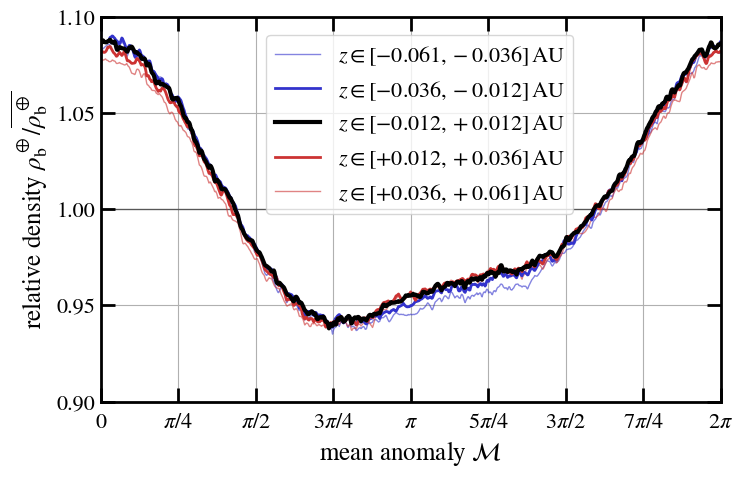

In [17]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.axhline(1,color=(0,0,0,0.5),lw=1)
ax.plot(M_sample,dens_sample_m2/np.mean(dens_sample),lw=1,color=(0.2,0.2,0.8,0.6),label=r'$z \in [-0.061,-0.036]\,\mathrm{AU}$');
ax.plot(M_sample,dens_sample_p2/np.mean(dens_sample),lw=1,color=(0.8,0.2,0.2,0.6),label=r'$z \in [+0.036,+0.061]\,\mathrm{AU}$');
ax.plot(M_sample,dens_sample_m/np.mean(dens_sample),lw=2,color=(0.2,0.2,0.8,1),label=r'$z \in [-0.036,-0.012]\,\mathrm{AU}$');
ax.plot(M_sample,dens_sample_p/np.mean(dens_sample),lw=2,color=(0.8,0.2,0.2,1),label=r'$z \in [+0.012,+0.036]\,\mathrm{AU}$');
ax.plot(M_sample,dens_sample/np.mean(dens_sample),color=(0,0,0,1),lw=3,label=r'$z \in [-0.012,+0.012]\,\mathrm{AU}$');
ax.set_xlim(0,2*np.pi);
ax.set_xticks(np.arange(0,2*np.pi+1e-10,np.pi/4))
ax.set_xticklabels([0,r'$\pi/4$','$\pi/2$','$3\pi/4$','$\pi$','$5\pi/4$','$3\pi/2$','$7\pi/4$','$2\pi$'])
ax.set_xlabel(r'mean anomaly $\mathcal{M}$')
ax.set_ylabel(r'relative density $\rho_\mathrm{b}^\oplus / \overline{\rho_\mathrm{b}^\oplus}$')
#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
#specify order of items in legend
order = [0,2,4,3,1]
#add legend to plot
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc='upper center', bbox_to_anchor=(0.515,1.01))
ax.set_ylim(0.9,1.10);
#ax.set_title(r"basin density along Earth's orbit at J2000")
ax.grid()
fig.savefig('../../figs/dens_height_M.pdf',bbox_inches='tight')
fig

### DFT analysis

In [18]:
len(dens_sample)

1024

In [19]:
dens_sample_fft = np.fft.rfft(dens_sample)
dens_sample_freq = np.fft.rfftfreq(n_sample,1/n_sample)

In [20]:
np.shape(dens_sample_fft),np.shape(dens_sample_freq)

((513,), (513,))

In [21]:
fig,ax=plt.subplots(1,1,figsize=(2,1))
ax.hist(np.real(dens_sample_fft/np.sum(dens_sample_fft_strap,axis=0))); #these must be very close to 1

In [22]:
res_fft_real = np.load(data_dir+'res_fft_real.npy')
res_fft_imag = np.load(data_dir+'res_fft_imag.npy')

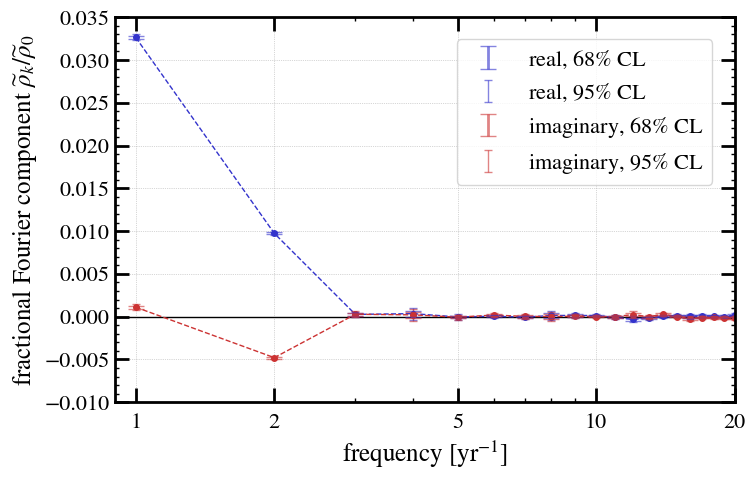

In [23]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.axhline(0,color=(0,0,0),lw=1)
ax.plot(dens_sample_freq[1:],res_fft_real[1:,0]/res_fft_real[0,0],color=(0.2,0.2,0.8),marker='.',ms=8,lw=1,ls='dashed')
ax.plot(dens_sample_freq[1:],res_fft_imag[1:,0]/res_fft_real[0,0],color=(0.8,0.2,0.2),marker='.',ms=8,lw=1,ls='dashed')
ax.errorbar(dens_sample_freq[1:],res_fft_real[1:,0]/res_fft_real[0,0],
            yerr=[np.abs((res_fft_real[1:,3]-res_fft_real[1:,0])/res_fft_real[0,0]),np.abs((res_fft_real[1:,4]-res_fft_real[1:,0])/res_fft_real[0,0])],
           color=(0.2,0.2,0.8,0.6),capsize=3,label=r'real, $95\%$ CL',lw=0,elinewidth=1)
ax.errorbar(dens_sample_freq[1:],res_fft_real[1:,0]/res_fft_real[0,0],
            yerr=[np.abs((res_fft_real[1:,1]-res_fft_real[1:,0])/res_fft_real[0,0]),np.abs((res_fft_real[1:,2]-res_fft_real[1:,0])/res_fft_real[0,0])],
           color=(0.2,0.2,0.8,0.6),capsize=6,label=r'real, $68\%$ CL',lw=0,elinewidth=2)
ax.errorbar(dens_sample_freq[1:],res_fft_imag[1:,0]/res_fft_real[0,0],
            yerr=[np.abs((res_fft_real[1:,3]-res_fft_real[1:,0])/res_fft_real[0,0]),np.abs((res_fft_real[1:,4]-res_fft_real[1:,0])/res_fft_real[0,0])],
           color=(0.8,0.2,0.2,0.6),capsize=3,label=r'imaginary, $95\%$ CL',lw=0,elinewidth=1)
ax.errorbar(dens_sample_freq[1:],res_fft_imag[1:,0]/res_fft_real[0,0],
            yerr=[np.abs((res_fft_real[1:,1]-res_fft_real[1:,0])/res_fft_real[0,0]),np.abs((res_fft_real[1:,2]-res_fft_real[1:,0])/res_fft_real[0,0])],
           color=(0.8,0.2,0.2,0.6),capsize=6,label=r'imaginary, $68\%$ CL',lw=0,elinewidth=2)
#ax.plot(dens_sample_freq[1:],res_fft_real[1:,0]/res_fft_real[0,0],color=(0.2,0.2,0.8,1),lw=0.5)
#ax.plot(dens_sample_freq[1:],res_fft_imag[1:,0]/res_fft_real[0,0],color=(0.8,0.2,0.2,1),lw=0.5)
#ax.fill_between(dens_sample_freq[1:],res_fft_real[1:,1]/res_fft_real[0,0],res_fft_real[1:,2]/res_fft_real[0,0])
ax.set_xscale('log');
#ax.set_yscale('symlog', linthresh=0.001, linscale=0.2);
ax.set_xlim(0.9,20)
ax.set_ylim(-0.01,0.035);
ax.set_yticks(np.arange(-0.01,0.035,0.001),minor=True)
ax.set_yticks(np.arange(-0.01,0.036,0.005),minor=False)
ax.set_xticks([1,2,5,10,20],minor=False)
ax.set_xticks(np.concatenate([np.arange(1,10,1),np.arange(10,30,10)]),minor=True)
ax.set_xticklabels([1,2,5,10,20])
ax.grid(lw=0.5,ls='dotted'); ax.legend();
ax.set_xlabel(r'frequency $[\mathrm{yr}^{-1}]$');
ax.set_ylabel(r'fractional Fourier component $\widetilde{\rho}_k / \widetilde{\rho}_0$');
#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
#specify order of items in legend
order = [1,0,3,2]
#add legend to plot
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc='upper right');
fig.savefig('../../figs/dens_DFT_M.pdf',bbox_inches='tight')
fig

In [24]:
np.concatenate([np.arange(1,10,1),np.arange(10,100,10)])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 20, 30, 40, 50, 60, 70, 80,
       90])

In [25]:
print((res_fft_real[1:3,0]+1j*res_fft_imag[1:3,0])/res_fft_real[0,0])
print(((res_fft_real[1:3,1]+1j*res_fft_imag[1:3,1])-(res_fft_real[1:3,0]+1j*res_fft_imag[1:3,0]))/res_fft_real[0,0])
print(((res_fft_real[1:3,2]+1j*res_fft_imag[1:3,2])-(res_fft_real[1:3,0]+1j*res_fft_imag[1:3,0]))/res_fft_real[0,0])

[0.03263266+0.00110109j 0.00973237-0.00479486j]
[-0.0001858 -0.0001802j  -0.00010988-0.00012138j]
[0.00016974+0.00016499j 0.00010783+0.0001128j ]


modulation amplitudes

In [26]:
2*np.abs((res_fft_real[1:3,0]+1j*res_fft_imag[1:3,0])/res_fft_real[0,0])

array([0.06530246, 0.02169881])

phase offsets

In [27]:
np.arctan(-res_fft_imag[1:3,0]/res_fft_real[1:3,0])

array([-0.03372923,  0.45776769])

day offsets

In [28]:
365.2422 * np.arctan(-res_fft_imag[1:3,0]/res_fft_real[1:3,0]) / (2*np.pi)

array([-1.96068371, 26.61008251])

### Real-space variation + best-fit

In [29]:
res_fft_real.shape

(513, 5)

In [30]:
res_real = np.zeros((dens_sample_strap.shape[1],5)); #mean, lo 68, hi 68, lo 95, hi 95

In [32]:
res_real = np.load(data_dir+'res_real.npy')

In [33]:
dens_fit = (res_fft_real[1,0]+1j*res_fft_imag[1,0])/res_fft_real[0,0]*(np.exp(1j*M_sample)) + (res_fft_real[2,0]+1j*res_fft_imag[2,0])/res_fft_real[0,0]*(np.exp(2j*M_sample))
dens_fit = np.real(1 + dens_fit + np.conjugate(dens_fit))
dens_fit

array([1.08473005, 1.08483152, 1.08492759, ..., 1.08439336, 1.08451095,
       1.08462318])

In [34]:
res_fft_real[1,0]/res_fft_real[0,0]

0.03263265783247735

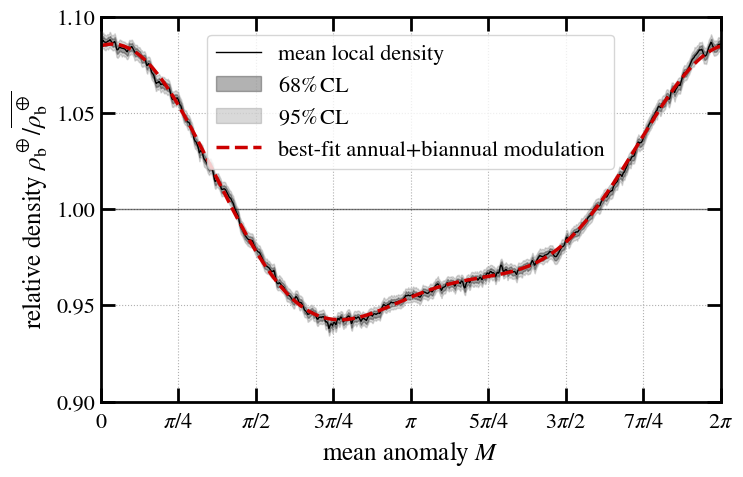

In [35]:
fig,ax = plt.subplots(1,1,figsize=(8,5))
ax.axhline(1,color=(0,0,0,0.5),lw=1)
ax.plot(M_sample,res_real[:,0]/np.mean(res_real[:,0]),color=(0,0,0,1),lw=1,label='mean local density')
ax.fill_between(M_sample,res_real[:,1]/np.mean(res_real[:,0]),res_real[:,2]/np.mean(res_real[:,0]),
                color=(0,0,0,0.3),label='$68\%\,\mathrm{CL}$')
ax.fill_between(M_sample,res_real[:,3]/np.mean(res_real[:,0]),res_real[:,4]/np.mean(res_real[:,0]),
                color=(0,0,0,0.15),label='$95\%\,\mathrm{CL}$')
ax.plot(M_sample,dens_fit,color=(0.8,0,0),ls='dashed',label='best-fit annual+biannual modulation')
ax.set_xlim(0,2*np.pi);
ax.set_xticks(np.arange(0,2*np.pi+1e-10,np.pi/4))
ax.set_xticklabels([0,'$\pi/4$','$\pi/2$','$3\pi/4$','$\pi$','$5\pi/4$','$3\pi/2$','$7\pi/4$','$2\pi$'])
ax.set_xlabel(r'mean anomaly $M$')
ax.set_ylabel(r'relative density $\rho_\mathrm{b}^\oplus / \overline{\rho_\mathrm{b}^\oplus}$')
#get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()
#specify order of items in legend
order = [0,2,3,1]
#add legend to plot
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc='upper center', bbox_to_anchor=(0.5,1.01))
ax.set_ylim(0.9,1.10);
#ax.set_title(r"basin density along Earth's orbit at J2000")
ax.grid(ls='dotted')
fig.savefig('../../figs/dens_CL_M.pdf',bbox_inches='tight')
fig

In [ ]:
dens_sample_fft_strap.shape

## Slice plot

In [126]:
list_slice_plot = np.arange(5,100,11); print(list_slice_plot)

[ 5 16 27 38 49 60 71 82 93]


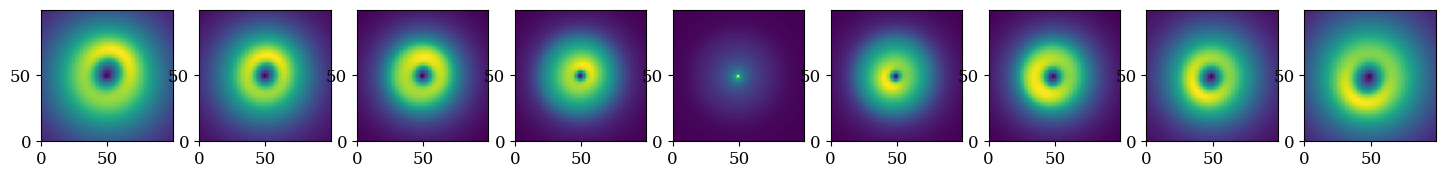

In [127]:
fig,ax = plt.subplots(1,9,figsize=(18,2))
for i in range(len(ax)):
    ax[i].pcolormesh(np.transpose(hist[:,:,list_slice_plot[i]]));
    ax[i].set_aspect(1)
fig

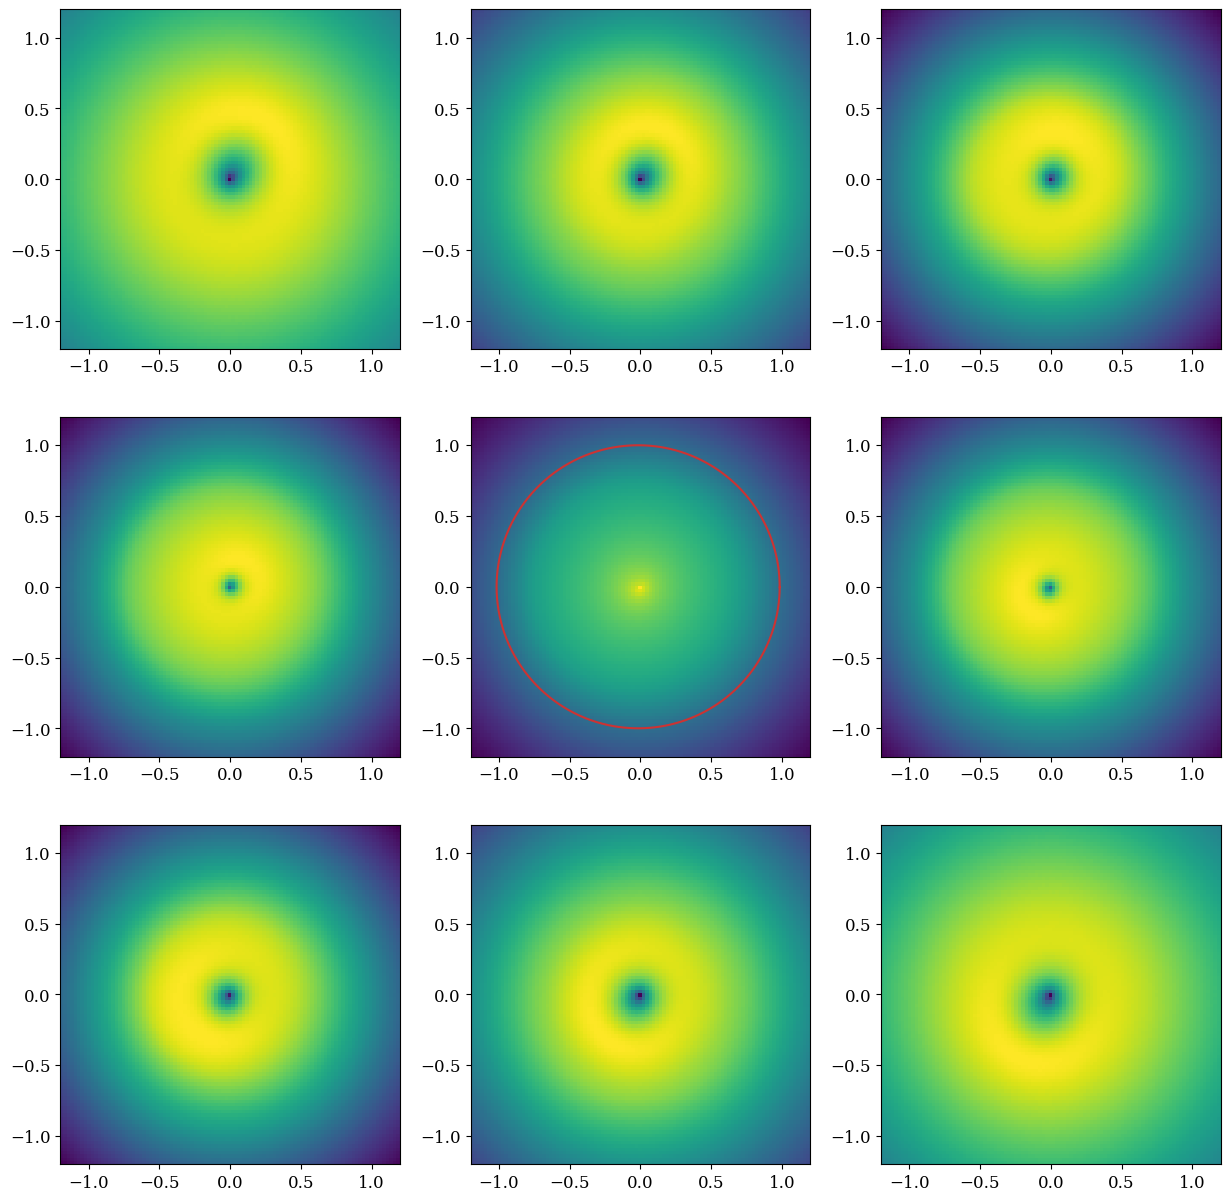

In [128]:
fig,ax = plt.subplots(3,3,figsize=(15,15))
for i in range(3):
    for j in range(3):
        ax[i,j].pcolormesh(bins_xy,bins_xy,np.transpose(hist[:,:,list_slice_plot[3*i+j]]),norm=mp.colors.LogNorm());
        ax[i,j].set_aspect(1)
ax[1,1].plot(pts_xy_Earth_orbit[0,:],pts_xy_Earth_orbit[1,:],color=(0.8,0.2,0.2));
fig

# Plot of orbits

In [80]:
n_a = int(1e3)
a_min = 0.5
a_max = 2
vec_a = np.arange(a_min,a_max,(a_max-a_min)/n_a)
prob_a = vec_a**(-2)/np.sum(vec_a**(-2)); # pdf that scales as f(a) \propto 1/a^2

n_e = int(1e3)
e_min = 0.9
e_max = 1
vec_e = np.arange(e_min,e_max,(e_max-e_min)/n_e)
prob_e = vec_e**0 / np.sum(vec_e**0) # pdf scales as f(e) \propto e

n_inc = int(1e3)
inc_min = 0
inc_max = np.pi
vec_inc = np.arange(inc_min,inc_max,(inc_max-inc_min)/n_inc)
prob_inc = np.sin(vec_inc) / np.sum(np.sin(vec_inc))

n_points = int(1e4)
t = 0
n_orbits = int(1e3)

In [81]:
arr_pts_xyz_E = np.zeros((n_orbits,n_points,3))
for l in tqdm(range(n_orbits)):
    a_0 = vec_a[np.random.choice(n_a,1,p=prob_a)]
    e_0 = vec_e[np.random.choice(n_e,1,p=prob_e)]
    inc_0 = vec_inc[np.random.choice(n_inc,1,p=prob_inc)]
    t_0 = np.random.random(1)*(-4.6e9*yr) #make these random to avoid possible aliasing
    omega_0 = np.random.random()*2*np.pi #random omega
    Omega_0 = np.random.random()*2*np.pi #random Omega
    arr_pts_xyz_E[l] = fn_gen_pts_xyz_E(e_0,inc_0,omega_0,Omega_0,a_0,t_0,t,df_planets,e_il,inc_il,g_l,f_l,beta_l,gamma_l,n_points)

  0%|          | 0/1000 [00:00<?, ?it/s]/mnt/home/kvantilburg/miniconda3/envs/ss_sim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/mnt/home/kvantilburg/solar-basin-dynamics/code/secular_pt_fun.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray([fn_alpha_bar(a,a_i) for  a_i in df_planets['a']])
/mnt/home/kvantilburg/solar-basin-dynamics/code/secular_pt_fun.py:39: RuntimeWarning: invalid value encountered in arcsin
  r

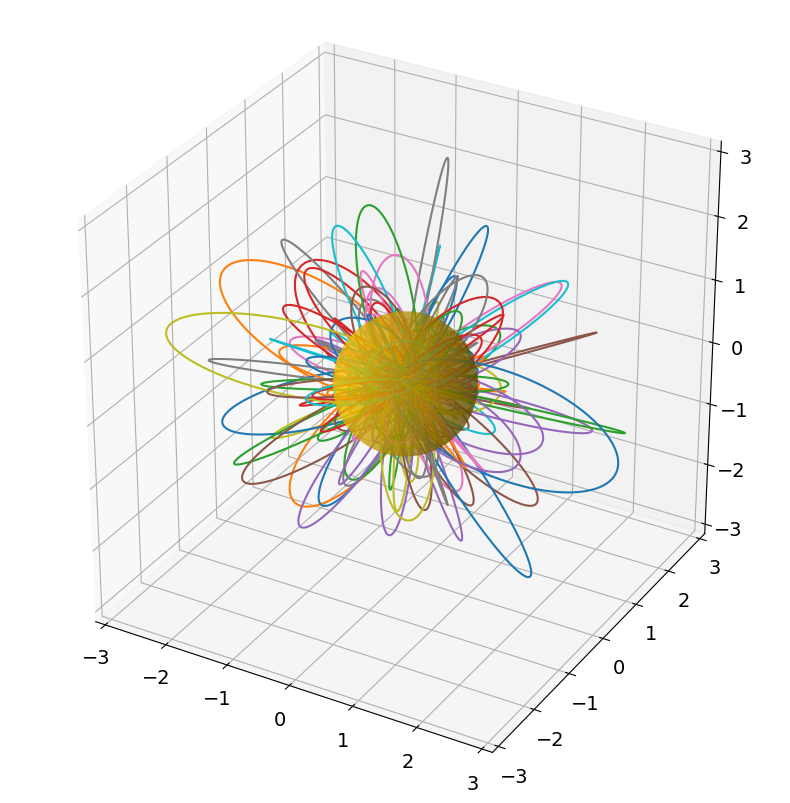

In [117]:
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
#ax.view_init(elev=0.,azim=180);
N=100
stride=1
n_orbits_plot = 200
box_size = np.nanmax(np.abs(arr_pts_xyz_E[:n_orbits_plot]))
u = np.linspace(0, 2 * np.pi, N)
v = np.linspace(0, np.pi, N)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))
ax.plot_surface(x, y, z, linewidth=0.0, cstride=stride, rstride=stride, color=(1,0.8,0,0.6))
ax.set_box_aspect((1,1,1))  # aspect ratio is 1:1:1 in data space
ax.set_xlim(-box_size,box_size)
ax.set_ylim(-box_size,box_size)
ax.set_zlim(-box_size,box_size)
for l in range(n_orbits_plot):
    ax.plot3D(arr_pts_xyz_E[l,:,0],arr_pts_xyz_E[l,:,1],arr_pts_xyz_E[l,:,2])
ax.set_axis_on()
plt.savefig(fig_dir+'orbits_sun.pdf',format='pdf')
fig

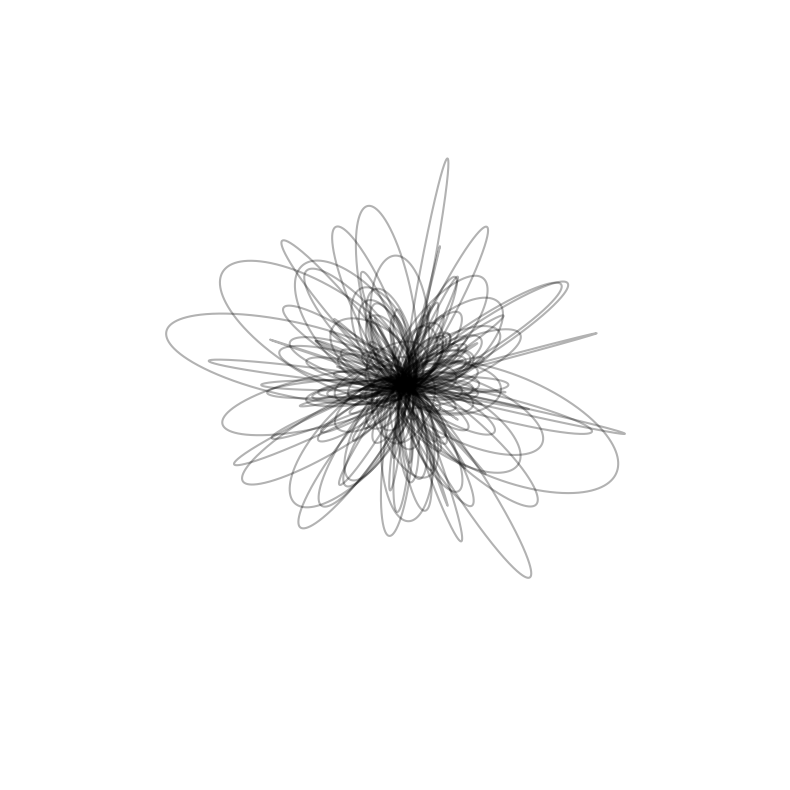

In [118]:
from mpl_toolkits import mplot3d
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
#ax.view_init(elev=0.,azim=180);
N=100
stride=1
n_orbits_plot = 200
box_size = np.nanmax(np.abs(arr_pts_xyz_E[:n_orbits_plot]))
u = np.linspace(0, 2 * np.pi, N)
v = np.linspace(0, np.pi, N)
x = np.outer(np.cos(u), np.sin(v))
y = np.outer(np.sin(u), np.sin(v))
z = np.outer(np.ones(np.size(u)), np.cos(v))
#ax.plot_surface(x, y, z, linewidth=0.0, cstride=stride, rstride=stride, color=(1,0.8,0,0.6))
ax.set_box_aspect((1,1,1))  # aspect ratio is 1:1:1 in data space
ax.set_xlim(-box_size,box_size)
ax.set_ylim(-box_size,box_size)
ax.set_zlim(-box_size,box_size)
for l in range(n_orbits_plot):
    ax.plot3D(arr_pts_xyz_E[l,:,0],arr_pts_xyz_E[l,:,1],arr_pts_xyz_E[l,:,2],color=(0,0,0,0.3))
ax.set_axis_off()
plt.savefig(fig_dir+'orbits_no_sun.pdf',format='pdf')
fig